In [1]:
import torch
import torch.nn as nn
from scipy.io import loadmat
import numpy as np
import random as rand
import mlmodel
import math
import pickle as pkl
import chart_studio.plotly as py
from importlib import reload
import plotly.graph_objects as go
from functools import reduce

import pose_2D as pose2d
import pose_3D as pose3d
import visual as vs

from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

In [2]:
import pose_2D_torch as pose2dtorch
import pose_3D_torch as pose3dtorch

In [3]:
pose2dtorch = reload(pose2dtorch)
pose3dtorch = reload(pose3dtorch)

In [4]:
import time, sys
from IPython.display import clear_output

def update_progress(progress,  message):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)
    for m in message:
        print(m)

In [5]:
pose2d = reload(pose2d)
pose3d = reload(pose3d)
vs = reload(vs)

In [6]:
torch.cuda.is_available()

True

In [7]:
#device = torch.device("cpu")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
torch.cuda.set_device(device)
torch.cuda.current_device()

0

In [9]:
!nvidia-smi

Tue Dec  3 16:14:02 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.26       Driver Version: 430.26       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:01:00.0 Off |                  N/A |
| 26%   33C    P8     5W / 250W |     27MiB / 11016MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  Off  | 00000000:03:00.0 Off |                  N/A |
| 24%   31C    P8     9W / 257W |   1738MiB / 11019MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

## 1- Load

In [10]:
list_body = ['neck','shoulder','biceps','forearm','quad','tibias','hip','back']
list_face = ['nose', 'eye', 'ear']

#### code for generating the original pose from proportions

base_3dpose_data = []
for i, ind in enumerate(data_set_props):
    if not i%1000:
        update_progress(i/len(data_set_props),['hey'])
    body_prop = dict(zip(list_body, [ind[0],ind[1],ind[2],ind[3],ind[4],ind[5],ind[6],ind[7]]))
    face_pos = dict(zip(list_face, [[ind[8],ind[9],ind[10]],[ind[11],ind[12],ind[13]],[ind[14],ind[15],ind[16]]]))
    base_3dpose_data.append(pose2d.generate_3D_model(body_prop, face_pos).reshape((21,3)).transpose())

pkl.dump((np.array(data_set_3d), np.array(data_set_2d), np.array(data_set_angles), np.array(data_set_props),\
          np.array(data_depths), np.array(base_3dpose_data)), open( "data/DATASETv_4.pkl", "wb" ))

In [11]:
data_set_3d, data_set_2d, data_set_angles, data_set_props,data_depths, base_3dpose_data = \
                                                                        pkl.load(open("data/DATASETv_5a.pkl", "rb"))

In [12]:
db2 = pkl.load(open("data/DATASETv_5b.pkl", "rb"))

In [13]:
data_set_3d = np.concatenate((data_set_3d, db2[0]))
data_set_2d = np.concatenate((data_set_2d, db2[1]))
data_set_angles = np.concatenate((data_set_angles, db2[2]))
data_set_props = np.concatenate((data_set_props, db2[3]))
data_depths = np.concatenate((data_depths, db2[4]))
base_3dpose_data = np.concatenate((base_3dpose_data, db2[5]))

In [14]:
del db2

In [15]:
db2 = pkl.load(open("data/DATASETv_5c.pkl", "rb"))

In [16]:
data_set_3d = np.concatenate((data_set_3d, db2[0]))
data_set_2d = np.concatenate((data_set_2d, db2[1]))
data_set_angles = np.concatenate((data_set_angles, db2[2]))
data_set_props = np.concatenate((data_set_props, db2[3]))
data_depths = np.concatenate((data_depths, db2[4]))
base_3dpose_data = np.concatenate((base_3dpose_data, db2[5]))

In [17]:
del db2

In [18]:
db2 = pkl.load(open("data/DATASETv_5d.pkl", "rb"))

In [21]:
data_set_3d = np.concatenate((data_set_3d, db2[0]))
data_set_2d = np.concatenate((data_set_2d, db2[1]))
data_set_angles = np.concatenate((data_set_angles, db2[2]))
data_set_props = np.concatenate((data_set_props, db2[3]))
data_depths = np.concatenate((data_depths, db2[4]))
base_3dpose_data = np.concatenate((base_3dpose_data, db2[5]))

In [22]:
del db2

In [23]:
print(data_set_2d.shape)
print(data_set_props.shape)
print(data_depths.shape)
print(data_set_angles.shape)
print(base_3dpose_data.shape)

(14632852, 42)
(14632852, 17)
(14632852,)
(14632852, 17)
(14632852, 3, 21)


In [24]:
min(data_depths)

0.24199431463068877

In [25]:
data_depths = data_depths.reshape(len(data_depths), 1)
inputs = np.concatenate((data_set_2d, data_set_props), axis=1)
labels = np.concatenate((data_set_angles, data_depths), axis=1)

In [26]:
del data_set_2d, data_set_props, data_set_angles, data_depths

In [27]:
labels.shape

(14632852, 18)

In [28]:
i=800
(a0,a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12,a13,a14,a15,a16) = data_set_angles[i]
angle_dic = {'head':[a0,a1,a2], 'back':[a3,a4,a5], 'x':[a6],'y':[a7], 'z':[a8], 'left arm':[a9,a10,a11,a12],
            'right arm':[a13,a14,a15,a16]}
test0 = pose3d.full_pose_rotation(base_3dpose_data[i], angle_dic).transpose().flatten()
go.Figure(vs.plot([test0, data_set_3d[i]]))

NameError: name 'data_set_angles' is not defined

### b- Sample the large data

In [30]:
sample_size = 14500000
sample_inputs, sample_labels, sample_base_3dpose = zip(*rand.sample(list(zip(inputs, labels, base_3dpose_data)),
                                                                    sample_size))

In [31]:
del inputs, labels, base_3dpose_data

In [32]:
train_inputs = np.array(list(sample_inputs[:int(0.8*sample_size)]))
train_labels = np.array(list(sample_labels[:int(0.8*sample_size)]))
train_base_3dpose = np.array(list(sample_base_3dpose[:int(0.8*sample_size)]))
val_inputs = np.array(list(sample_inputs[int(0.8*sample_size):]))
val_labels = np.array(list(sample_labels[int(0.8*sample_size):]))
val_base_3dpose = np.array(list(sample_base_3dpose[int(0.8*sample_size):]))

In [33]:
del sample_inputs, sample_labels, sample_base_3dpose

In [34]:
val_labels.shape

(2900000, 18)

### c- add random input occlusion

In [35]:
def add_occlusion(pedestrian):
    dim = int(pedestrian.shape[0]/14)
    pedestrian = pedestrian.reshape((14,dim)).transpose()
    states = [ 'left wrist occluded', 'right wrist occluded', ]

## 2- create and prepare model

In [55]:
net = mlmodel.LinearModel(59, 18, num_stage=5)

In [56]:
device

device(type='cuda', index=0)

In [57]:
net = net.to(device)


### a- prepare data loader and learning rate decay

In [39]:
class PrepareData(Dataset):
    def __init__(self, X, Y, BasePose):
        if not torch.is_tensor(X):
            self.X = torch.from_numpy(X).float()

        if not torch.is_tensor(Y):
            self.Y = torch.from_numpy(Y).float()
            
        if not torch.is_tensor(BasePose):
            self.BasePose = torch.from_numpy(BasePose).float()
        
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx], self.BasePose[idx]

In [40]:
loss = nn.MSELoss()
def step_decay(epoch):
    initial_lrate = 0.0001
    drop = 0.8
    epochs_drop = 50.0
    lrate = initial_lrate * math.pow(drop,
                                     math.floor((1+epoch)/epochs_drop))
    return lrate

In [41]:
step_decay(70)

8e-05

In [42]:
size_batches = 5000
ds = PrepareData(X=train_inputs, Y=train_labels, BasePose=train_base_3dpose)

ds = DataLoader(ds, batch_size = size_batches, shuffle=True)



In [43]:
def project_to_pixels(xyz, kk):
    """Project a single point in space into the image"""
    xx, yy, zz = np.dot(kk, xyz)
    uu = int(xx / zz)
    vv = int(yy / zz)

    return uu, vv

In [44]:
def project_pose_2cam(pose, kk, z_shift, joints2keep):
    
    pose_moved = pose.copy()
    pose_moved[2] += z_shift
    projected_pose = []
    
    for point in pose_moved.transpose():
        projected_pose.append(list(project_to_pixels(point, kk)))
    
    projected_pose = np.array(projected_pose).transpose()
    projected_pose = pose2d.filter_joints(projected_pose, joints2keep, 0)
    projected_pose = pose2d.normalize(projected_pose)
    projected_pose = pose2d.filter_joints(projected_pose, joints2keep, -10).transpose().flatten()
    
    return projected_pose

In [45]:
def project_to_pixels(all_points, kk):
    """Project a single point in space into the image"""
    
    mat = [kk for _ in all_points]
    
    xx, yy, zz = torch.dot(kk, xyz)
    uu = xx / zz
    vv = yy / zz

    return uu, vv

# on test des trucs la

#### define the data we try on

In [46]:
pose2dtorch = reload(pose2dtorch)
pose3dtorch = reload(pose3dtorch)

In [47]:
joints2keep = ['left hip', 'right hip', 'nose', 'right shoulder','left shoulder', 'right eye','left eye',
               'right ear','left ear','center shoulder','center hip','center back','head', 'right elbow',
              'right wrist', 'left elbow', 'left wrist']

In [77]:
list_of_poses = np.array([x.transpose().flatten() for x in base_3dpose_data[900:950]])
list_of_angles = torch.from_numpy(data_set_angles[900:950]).float().to(device)
z_shifts = data_depths[900:950]
z_shifts = torch.from_numpy(z_shifts.reshape((len(z_shifts,)))).float().to(device)

list_of_poses = torch.from_numpy(list_of_poses).float().to(device).reshape((50,21,3)).transpose(1,2)#.transpose(2,1)
test = list_of_poses.clone().detach()
list_of_poses[0].cpu().detach().numpy()

array([[ 0.        , -0.22904128, -0.22904128, -0.22904128,  0.22904128,
         0.22904128,  0.22904128, -0.11719298, -0.11719298, -0.11719298,
         0.11719298,  0.11719298,  0.11719298, -0.03145004,  0.03145004,
        -0.0840834 ,  0.0840834 ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [-0.9293451 , -0.6760724 , -0.39002997, -0.12677838, -0.6760724 ,
        -0.39002997, -0.12677838,  0.        ,  0.35680974,  0.6936541 ,
         0.        ,  0.35680974,  0.6936541 , -0.9656622 , -0.9656622 ,
        -0.9293451 , -0.9293451 , -0.80270875,  0.        , -0.3380362 ,
        -0.9293451 ],
       [ 0.12142092,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.06161395,  0.06161395,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ]], dtype=float32)

In [78]:
%%prun
# we start with creating the angle dicts
i = 29
batch_size = list_of_angles.size()[0]

angle_dic = {'head':list_of_angles[:,:3], 'back':list_of_angles[:,3:6],
             'x':list_of_angles[:,6].reshape((batch_size,1)),
             'y':list_of_angles[:,7].reshape((batch_size,1)),
             'z':list_of_angles[:,8].reshape((batch_size,1)),
             'left arm':list_of_angles[:,9:13],'right arm':list_of_angles[:,13:]}
test = pose3dtorch.tensor_full_pose_rotation(test, angle_dic, device=device)#[i].cpu().detach().numpy().transpose().flatten()
#go.Figure(vs.plot([data_set_3d[900+i], test],upper_bod_co))

In [81]:
test3d = test[i].cpu().detach().numpy().transpose().flatten()
test_og = data_set_3d[900+i]
go.Figure(vs.plot([test3d, test_og]))

In [205]:
test[:,:,[2,8,3]]#.transpose(1,2).reshape((150,3,1))

tensor([[[-0.2178, -0.1066, -0.2178],
         [-0.3870,  0.3757, -0.1134],
         [ 0.0000,  0.0000,  0.0000]],

        [[-0.2310, -0.1177, -0.2310],
         [-0.3582,  0.3788, -0.0844],
         [ 0.0000,  0.0000,  0.0000]],

        [[-0.2157, -0.1151, -0.2157],
         [-0.3761,  0.3629, -0.1109],
         [ 0.0000,  0.0000,  0.0000]],

        [[-0.2437, -0.1204, -0.2437],
         [-0.4076,  0.3892, -0.1275],
         [ 0.0000,  0.0000,  0.0000]],

        [[-0.2044, -0.1091, -0.2044],
         [-0.3907,  0.3864, -0.1116],
         [ 0.0000,  0.0000,  0.0000]],

        [[-0.2202, -0.1136, -0.2202],
         [-0.4088,  0.3746, -0.1362],
         [ 0.0000,  0.0000,  0.0000]],

        [[-0.2100, -0.1173, -0.2100],
         [-0.3575,  0.3793, -0.0817],
         [ 0.0000,  0.0000,  0.0000]],

        [[-0.2523, -0.1196, -0.2523],
         [-0.3572,  0.3389, -0.1037],
         [ 0.0000,  0.0000,  0.0000]],

        [[-0.2140, -0.1139, -0.2140],
         [-0.3931,  0.3662, -0.124

In [207]:
test[:,:,[2,8,3]] == test[:,:,[2,8,3]].transpose(1,2).reshape((150,3,1)).reshape((50,3,3)).transpose(1,2)

tensor([[[True, True, True],
         [True, True, True],
         [True, True, True]],

        [[True, True, True],
         [True, True, True],
         [True, True, True]],

        [[True, True, True],
         [True, True, True],
         [True, True, True]],

        [[True, True, True],
         [True, True, True],
         [True, True, True]],

        [[True, True, True],
         [True, True, True],
         [True, True, True]],

        [[True, True, True],
         [True, True, True],
         [True, True, True]],

        [[True, True, True],
         [True, True, True],
         [True, True, True]],

        [[True, True, True],
         [True, True, True],
         [True, True, True]],

        [[True, True, True],
         [True, True, True],
         [True, True, True]],

        [[True, True, True],
         [True, True, True],
         [True, True, True]],

        [[True, True, True],
         [True, True, True],
         [True, True, True]],

        [[True, True,

In [37]:
test = pose2dtorch.tensor_project_pose_2cam(test, pose2d.kk, z_shifts, joints2keep)

TypeError: 'int' object is not callable

In [36]:
upper_bod_co = [(0,20),(0,13),(0,14),(13,15),(14,16),(20,17),(1,4),(1,2),(2,3),(4,5),(5,6),(17,19),
                    (19,18),(18,7),(18,10)]
test = test[i].cpu().detach().numpy().transpose().flatten()
go.Figure(vs.plot([test, data_set_2d[900+i]],upper_bod_co))

In [39]:
[list_of_poses[0].cpu().detach().numpy()]

[array([[ 0.        , -0.21784791, -0.21784791, -0.21784791,  0.21784791,
          0.21784791,  0.21784791, -0.10656582, -0.10656582, -0.10656582,
          0.10656582,  0.10656582,  0.10656582, -0.02837208,  0.02837208,
         -0.07895347,  0.07895347,  0.        ,  0.        ,  0.        ,
          0.        ],
        [-0.9572942 , -0.6963643 , -0.38704157, -0.11336072, -0.6963643 ,
         -0.38704157, -0.11336072,  0.        ,  0.37565735,  0.72884357,
          0.        ,  0.37565735,  0.72884357, -0.9939231 , -0.9939231 ,
         -0.9572942 , -0.9572942 , -0.82682925,  0.        , -0.34818214,
         -0.9572942 ],
        [ 0.11852451,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.059683  ,  0.059683  ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ]], dtype=float32)]

In [65]:
a = torch.tensor([-1,0,4,5,6,0,-2,4])<=0
b = torch.tensor([-1,0,4,5,6,0,-2,4])>0
torch.tensor([-1,0,4,5,6,0,-2,4]).float()*b.float()+a.float()*0.2

tensor([0.2000, 0.2000, 4.0000, 5.0000, 6.0000, 0.2000, 0.2000, 4.0000])

# on a fini

### b- infer data and find error between ground truth and prediction

In [48]:
def infer(inputs, model):
    with torch.no_grad():
        net = model
        net = net.to(device)
        net.eval()
        inputs = torch.from_numpy(inputs).float().to(device)
        outputs = net(inputs)
        outputs.cpu().detach().numpy()
    return outputs

In [49]:
def find_error(inputs, gt, model):
    pred = infer(inputs, model).cpu().numpy()
    return np.mean(np.linalg.norm(gt-pred, axis = 1))

In [50]:
def move_all_poses(poses, angles, device = torch.device("cuda:0")):
    batch_size = angles.size()[0]

    angle_dic = {'head':angles[:,:3], 'back':angles[:,3:6],
             'x':angles[:,6].reshape((batch_size,1)),
             'y':angles[:,7].reshape((batch_size,1)),
             'z':angles[:,8].reshape((batch_size,1)),
             'left arm':angles[:,9:13],'right arm':angles[:,13:]}
    poses = pose3dtorch.tensor_full_pose_rotation(poses, angle_dic, device)
    return poses

## 3- Train

In [51]:
joints2keep = ['left hip', 'right hip', 'nose', 'right shoulder','left shoulder', 'right eye','left eye',
               'right ear','left ear','center shoulder','center hip','center back','head', 'right elbow',
              'right wrist', 'left elbow', 'left wrist']

In [42]:
import time

### tensorboard init

In [52]:
from torch.utils.tensorboard import SummaryWriter

/home/jeanmarc/miniconda3/envs/DL-env/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/home/jeanmarc/miniconda3/envs/DL-env/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/home/jeanmarc/miniconda3/envs/DL-env/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/home/jeanmarc/miniconda3/envs/DL-env/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:544: FutureWarning:

Passing (type, 1) or '1type'

In [53]:
writer = SummaryWriter('logs/exp12')

In [ ]:

losses = []
message = ''
t_losses = []
v_losses = []

min_v_loss = np.inf

for epoch in range(0,250):
    optimizer = optim.Adam(net.parameters(), lr=step_decay(epoch))
    e_loss = []
    
    t_loss = find_error(train_inputs[:3000],train_labels[:3000], net)
    v_loss = find_error(val_inputs[:3000],val_labels[:3000], net)
    
    t_losses.append(t_loss)
    v_losses.append(v_loss)
    
    if v_loss<min_v_loss:
        min_v_loss = min(min_v_loss, v_loss)
        print('we save the weights')
        name = 'net-v0_6_14M_l1.pkl'
        torch.save(net.state_dict(), name)
    
    for i, data in enumerate(ds, 0):
        update_progress(i/len(ds),  [message])
        
        batch_inputs, batch_labels, batch_poses = data
        (batch_inputs, batch_labels, batch_poses) = (batch_inputs.to(device), batch_labels.to(device),\
                                                     batch_poses.to(device))
        optimizer.zero_grad()
        
        #batch_2_move = batch_poses.clone().detach()
        
        batch_outputs = net(batch_inputs)
        
        #print('we computed the output')
        
        #print(batch_poses.size())
        
        l1 = loss(batch_outputs, batch_labels)
        
        #batch_pred_depth = batch_outputs[:,17]
        
        #filter1 = batch_pred_depth<=0
        #fliter2 = batch_pred_depth>0
        
        #fixed_depth = filter1.float()*0.25 + batch_pred_depth.float() * fliter2.float()
    
        #batch_moved_poses = move_all_poses(batch_poses,batch_outputs[:,:17], device=device)
        
        #print('we moved the poses')
        
        #projections = pose2dtorch.tensor_project_pose_2cam(batch_moved_poses, pose2d.kk,
        #                                                   fixed_depth, joints2keep, device=device)

        #projections = torch.flatten(projections.transpose(1,2), start_dim=1)
        
        #print('we found the loss')
        #l2 = loss(projections, batch_inputs[:,:42])
        
        l = l1#+l2
        
        l.backward()
        optimizer.step()
        
        e_loss.append(l.cpu().detach().numpy())
        if not i%10:
            writer.add_scalar('training loss',
                            np.mean(e_loss) ,
                            epoch * len(ds) + i)
        message = str(epoch)+' train loss: '+ str(t_loss)+'\t val loss: '+str(v_loss)+'\t e_loss'+str(np.mean(e_loss))
        
    
        
        

Progress: [#########-----------] 46.9%
47 train loss: 1.160697143362385	 val loss: 1.2133523375536157	 e_loss0.10020349


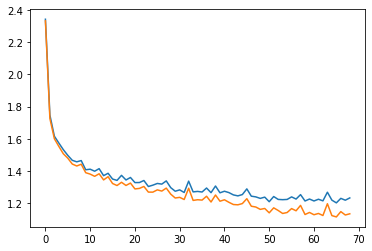

In [463]:
import matplotlib.pyplot as plt
plt.plot(np.array(v_losses[:250]))
plt.plot(np.array(t_losses[:250]))

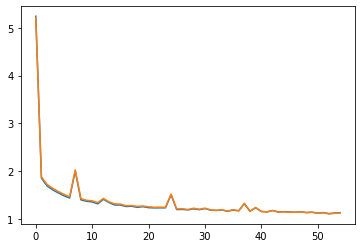

In [48]:
import matplotlib.pyplot as plt
plt.plot(np.array(v_losses[:250]))
plt.plot(np.array(t_losses[:250]))

In [49]:
#'train loss:', find_error(train_inputs,train_labels, net),
'\t val loss:', find_error(val_inputs,val_labels, net)

('\t val loss:', 1.1143558789786183)

In [465]:
name = 'net-v0_6_2M_l1.pkl'
torch.save(net.state_dict(), name)

In [396]:
params = torch.load('net-v0_5.pkl')
params = torch.load('net-v0_6_750k_l1.pkl')
net.load_state_dict(params)

<All keys matched successfully>

#### distance error

In [50]:
errors = []
for i in range(1000):
    test = infer(val_inputs[i:i+1],net).cpu().numpy()[0]
    gt = val_labels[i]
    errors.append(abs(test[-1]-gt[-1]))
print(np.mean(errors))

0.061291333203258046


In [51]:
find_error(val_inputs,val_labels, net)

1.1143558789786183

## 4- visualize a validation result

In [74]:
i = 500
test = infer(val_inputs[i:i+1],net).cpu().numpy()[0]
gt = val_labels[i]
print(test)
print(gt)

[ 7.2529799e-01 -1.8231305e-01 -4.5847097e-01  3.3020407e-02
 -1.8423109e-01 -5.1938814e-01 -9.4909132e-01  5.8007729e-01
  1.0941196e-03  1.5935347e+00  1.2455827e+00 -1.2199421e+00
  1.1165332e+00 -1.1502014e+00 -3.9643370e-02 -8.3465153e-01
 -2.2946389e+00  9.4171399e-01]
[ 0.76099608 -0.1748962  -0.37708726 -0.04065179 -0.28437223 -0.45404125
 -1.01009086  0.56242772 -0.05496874  1.45235474  1.13499584 -1.16565407
  1.24457079 -1.17466736  0.05477049 -0.95772363 -1.81404553  1.17188748]


In [75]:
props = val_inputs[i][42:]
list_body = ['neck','shoulder','biceps','forearm','quad','tibias','hip','back']
list_face = ['nose', 'eye', 'ear']

In [76]:
body_props = dict(zip(list_body, props[:8]))
face_pos = dict(zip(list_face, props[8:].reshape((3,3))))

In [77]:
base_3d_pose = pose2d.generate_3D_model(body_props, face_pos)

In [78]:
(a0,a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12,a13,a14,a15,a16,d_gt) = gt
angle_dic = {'head':[a0,a1,a2], 'back':[a3,a4,a5], 'x':[a6],'y':[a7], 'z':[a8], 'left arm':[a9,a10,a11,a12],
            'right arm':[a13,a14,a15,a16]}
gt_pose = pose3d.full_pose_rotation(base_3d_pose.reshape((21,3)).transpose(), angle_dic).transpose().flatten()

In [79]:
(a0,a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12,a13,a14,a15,a16,d_pred) = test
angle_dic = {'head':[a0,a1,a2], 'back':[a3,a4,a5], 'x':[a6],'y':[a7], 'z':[a8], 'left arm':[a9,a10,a11,a12],
            'right arm':[a13,a14,a15,a16]}
pred_pose = pose3d.full_pose_rotation(base_3d_pose.reshape((21,3)).transpose(), angle_dic).transpose().flatten()

In [80]:
upper_bod_co = [(0,20),(1, 2),(2, 3),(17, 20),(17,1),(17, 4),(17, 19),(19, 18),(4, 5),(5, 6),(0,13),(0,14),(13,15),(14,16),
            (18,7),(18,10)]
#go.Figure(vs.plot([inputs[i][:42]], torso_co))

In [81]:
d_gt, d_pred

(1.171887481154831, 0.941714)

In [82]:
go.Figure(vs.plot([np.array([x if x>-9 else 0 for x in val_inputs[i][:42]])]), upper_bod_co)

In [83]:
go.Figure(vs.plot([gt_pose, pred_pose]))

## 5- Trying on real people

#### a- get the body proportions of the actors

run pifpaf on some calibation images

In [ ]:
! python3 -m openpifpaf.predict ./data/pifpaf/proportions_images/*  --force-complete-pose -o ./data/pifpaf/proportions_jsons/

In [84]:
pifpaf = pose2d.load_pifpaf('./data/pifpaf/proportions_jsons/')

we loaded 24 pedestrians


we have 2 actors in our testing

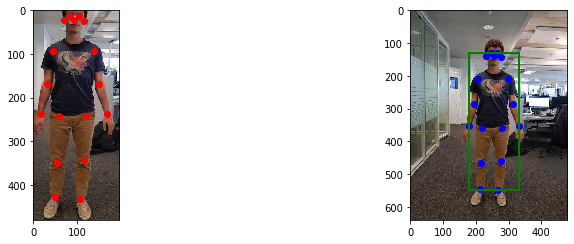

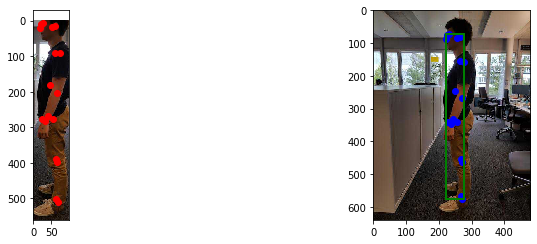

In [85]:
i=0
front_view = pifpaf[i]['conv_keypoints']
side_view = pifpaf[i+1]['conv_keypoints']
vs.show_pp_on_image(pifpaf[i],'./data/pifpaf/proportions_images/','.jpg')
vs.show_pp_on_image(pifpaf[i+1],'./data/pifpaf/proportions_images/','.jpg')

In [86]:
body_props_1, face_pos_1 = pose2d.get_proportions(front_view, side_view)

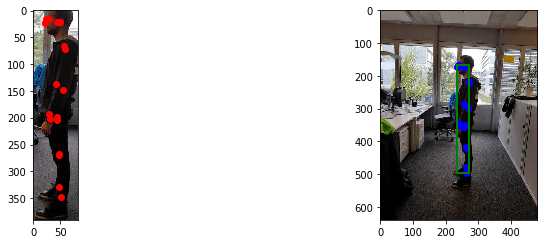

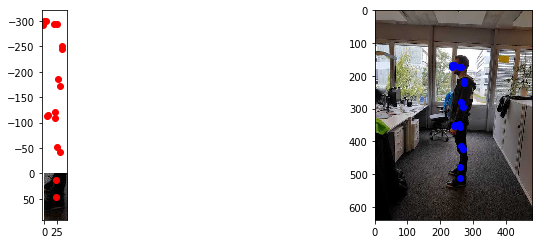

In [87]:
i=14
front_view = pifpaf[i]['conv_keypoints']
side_view = pifpaf[i+1]['conv_keypoints']
vs.show_pp_on_image(pifpaf[i],'./data/pifpaf/proportions_images/','.jpg')
vs.show_pp_on_image(pifpaf[i+1],'./data/pifpaf/proportions_images/','.jpg')

In [88]:
body_props_2, face_pos_2 = pose2d.get_proportions(front_view, side_view)

#### b- run the network on testing images

run pifpaf

In [ ]:
! python3 -m openpifpaf.predict ./data/pifpaf/test_images/*  --force-complete-pose -o ./data/pifpaf/test_jsons/

In [89]:
pifpaf = pose2d.load_pifpaf('./data/pifpaf/test_jsons/')

we loaded 15 pedestrians


In [90]:
pifpaf = [x for x in pifpaf if np.mean(x['confidence'])>0.2]

In [91]:
len(pifpaf)

12

In [92]:
joints2keep = ['left hip', 'right hip', 'nose', 'right shoulder','left shoulder', 'right eye','left eye',
               'right ear','left ear','center shoulder','center hip','center back','head', 'right elbow',
              'right wrist', 'left elbow', 'left wrist']

##### actor 1

In [93]:
preds_1 = []
input_poses = []
depths = []

for i in range(2,len(pifpaf)):
    test_input = pifpaf[i]['conv_keypoints']
    test_input = pose2d.filter_joints(test_input.reshape((21,2)).transpose(), joints2keep, 0)
    test_input = pose2d.normalize(test_input)
    test_input = pose2d.filter_joints(test_input, joints2keep, -10).transpose().flatten()
    input_poses.append(test_input)
    test_props = [x[1] for x in body_props_1.items()]+reduce(lambda x, y: x+y, [x[1] for x in face_pos_1.items()])
    test_input = np.concatenate((test_input, test_props), axis = 0)
    
    test = infer(np.array([test_input]),net).cpu().numpy()[0]
    
    base_3d_pose = pose2d.generate_3D_model(body_props_1, face_pos_1)
    
    (a0,a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12,a13,a14,a15,a16,d_pred) = test
    angle_dic = {'head':[a0,a1,a2], 'back':[a3,a4,a5], 'x':[a6],'y':[a7], 'z':[a8], 'left arm':[a9,a10,a11,a12],
            'right arm':[a13,a14,a15,a16]}
    depths.append(d_pred)
    pred_pose = pose3d.full_pose_rotation(base_3d_pose.reshape((21,3)).transpose(), angle_dic).transpose().flatten()
    
    preds_1.append(pred_pose)
    

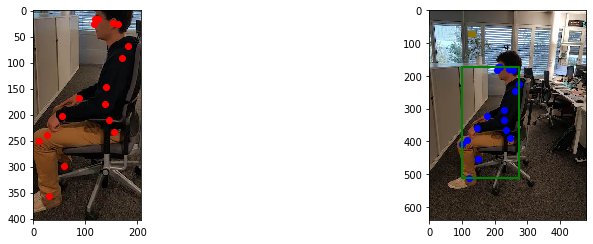

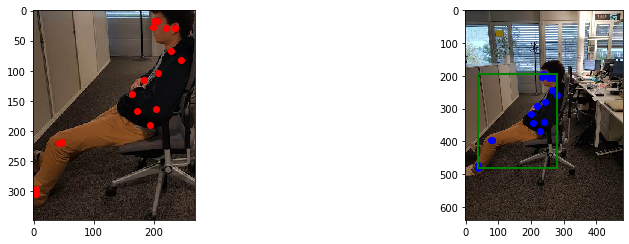

In [117]:
i,j = 2,9
vs.show_pp_on_image(pifpaf[i+2],'./data/pifpaf/test_images/','.jpg')
vs.show_pp_on_image(pifpaf[j+2],'./data/pifpaf/test_images/','.jpg')

In [118]:
go.Figure(vs.plot([preds_1[i],preds_1[j]]))

In [ ]:
def project_to_pixels(xyz, kk):
    """Project a single point in space into the image"""
    xx, yy, zz = np.dot(kk, xyz)
    uu = int(xx / zz)
    vv = int(yy / zz)

    return uu, vv
def project_pose_2cam(pose, kk, z_shift, joints2keep):
    
    pose_moved = pose.copy()
    pose_moved[2] += z_shift
    projected_pose = []
    
    for point in pose_moved.transpose():
        projected_pose.append(list(project_to_pixels(point, kk)))
    
    projected_pose = np.array(projected_pose).transpose().astype(float)
    joints_indices = [pose2d.joint_dict[x] for x in joints2keep]
    shift = (projected_pose[:,pose2d.joint_dict['right hip']] + 
             projected_pose[:,pose2d.joint_dict['left hip']]).reshape((2,1))/2
    projected_pose[:,joints_indices] = pose2d.normalize(projected_pose[:,joints_indices], shift)
    projected_pose = pose2d.filter_joints(projected_pose, joints2keep, -10).transpose().flatten()

    return projected_pose

In [ ]:
reproj_i = project_pose_2cam(preds_1[i].reshape((21,3)).transpose(), kk, depths[i], joints2keep)
reproj_j = project_pose_2cam(preds_1[j].reshape((21,3)).transpose(), kk, depths[j], joints2keep)

In [ ]:
pose2d.joint_dict

In [ ]:
upper_bod_co = [(0,20),(0,13),(0,14),(13,15),(14,16),(20,17),(1,4),(1,2),(2,3),(4,5),(5,6),(17,19),
                    (19,18),(18,7),(18,10)]
go.Figure(vs.plot([ input_poses[i],reproj_i], upper_bod_co))

In [ ]:
go.Figure(vs.plot(preds_1[5::2]))

##### actor 2

In [104]:
preds_2 = []

for i in range(2):
    test_input = pifpaf[i]['conv_keypoints']
    test_input = pose2d.filter_joints(test_input.reshape((21,2)).transpose(), joints2keep, 0)
    test_input = pose2d.normalize(test_input)
    test_input = pose2d.filter_joints(test_input, joints2keep, -10).transpose().flatten()
    
    test_props = [x[1] for x in body_props_2.items()]+reduce(lambda x, y: x+y, [x[1] for x in face_pos_2.items()])
    test_input = np.concatenate((test_input, test_props), axis = 0)
    
    test = infer(np.array([test_input]),net).cpu().numpy()[0]
    
    base_3d_pose = pose2d.generate_3D_model(body_props_1, face_pos_1)
    
    (a0,a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12,a13,a14,a15,a16,d_pred) = test
    angle_dic = {'head':[a0,a1,a2], 'back':[a3,a4,a5], 'x':[a6],'y':[a7], 'z':[a8], 'left arm':[a9,a10,a11,a12],
            'right arm':[a13,a14,a15,a16]}
    print(d_pred)
    pred_pose = pose3d.full_pose_rotation(base_3d_pose.reshape((21,3)).transpose(), angle_dic).transpose().flatten()
    
    preds_2.append(pred_pose)
    

1.1422105
1.2423139


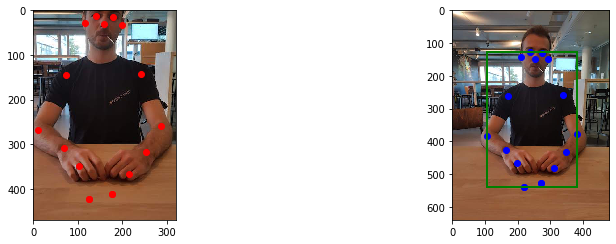

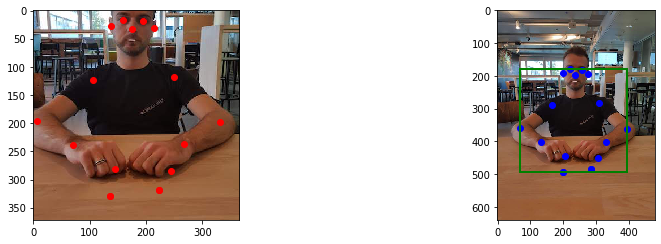

In [105]:
i,j = 0,1
vs.show_pp_on_image(pifpaf[i],'./data/pifpaf/test_images/','.jpg')
vs.show_pp_on_image(pifpaf[j],'./data/pifpaf/test_images/','.jpg')

In [106]:
go.Figure(vs.plot([ preds_2[i],preds_2[j]]))